# Correcting intensity fluctuations 

In [46]:
import numpy as np
import matplotlib.pyplot as plt
import pymc3 as pm
import pboc.mcmc
import theano.tensor as tt
import seaborn as sns
import glob
import pandas as pd
import sys
sys.path.insert(0, '../../../')
import mwc.viz
import mwc.process
import matlab.engine as matlab
eng = matlab.start_matlab()
colors = mwc.viz.set_plotting_style()
%matplotlib inline

## The problem 

It's possible that the factor of five difference in the calibration factor is coming from the flucutating intensity of the background. To correct for this, I will compute all pairwise squared fluctuations of the background and will subtract that factor from each cell division event. 

## Data processing

In [11]:

def cell_to_dict(file, eng, add_props=None, excluded_props=None):
    """
    Reads a single cell file and produces a dictionary containing
    the properties of interest.

    The returned properties are
    * birth - frame number at which the cell was born.
    * death - frame number at which the cell died.
    * divide - bool for an observed cell division.
    * ID - integer ID number of the cell.
    * motherID - integer ID number of the mother cell.
    * sisterID - integer ID number of the sister cell.
    * birth_fluo - fluorescence value at the cell's birth.
    * death_fluo - fluorescence value at the cell's death.
    * daughter_1_ID - integer ID number of the first daughter.
    * daughter_2_ID - integer ID number of the second daughter.


    Parameters
    ----------
    file: str
        Path of the cell file. This must be in a `.mat` format.
    eng: MATLAB engine object
        Engine of running matlab session.
    add_props : dict, default None
        Dictionary of additional properties (not found in the mat file)
        to be included in the returned dictionary.
    excluded_props: list of str
        Properties of cell.mat file to be ignored. These must be
        exactly how they are defined in the cell file.

    Returns
    -------
    cell_dict : dictionary
        Dictionary of all extracted properties from the cell files.
    """

    # Ensure the supplied file is actually a .mat and other types are correct.
    if file.split('.')[-1] != 'mat':
        raise TypeError("supplied file {0} is not a `.mat` file.".format(file))
    if add_props is not None and type(add_props) is not dict:
        raise TypeError(
            "add_props is {0} and not dict.".format(type(add_props)))
    if excluded_props is not None and type(excluded_props) is not list:
        raise TypeError(
            "add_props must be list. Type is currently {0}.".format(type(excluded_props)))

    # Define the values of interest.
    vals = ['birth', 'death', 'divide', 'ID', 'motherID', 'sisterID',
            'daughter_1_ID', 'daughter_2_ID', 'birth_fluo', 'death_fluo', 'birth_area', 'death_area']

    # Load the mat file using MATLAB.
    eng.workspace['f'] = file
    mat = eng.eval('load(f)')

    # Assemble the dictionary for constant properties.
    cell_dict = {v: mat[v] for v in vals[:-6]}
    daughters = np.array(mat['daughterID'])

    # Determine  if daughters were produced. If not, change ID to NaN.
    if len(daughters) == 0:
        daughter_1, daughter_2 = None,  None
    else:
        daughter_1, daughter_2 = daughters[0]
    cell_dict['daughter_1_ID'] = daughter_1
    cell_dict['daughter_2_ID'] = daughter_2

    # Extract fluorescence information -- This is a bit gross but checked.
    # Get number of fluorescence channels.
    fluo_channels = [f for f in mat['CellA'][0].keys() if 'fl' in f]
    n_channels = int(len(fluo_channels) / 3)
    for n in range(n_channels):
        _n = n + 1
        try:
            fluo = [mat['CellA'][i]['fl{0}'.format(
                _n)]['sum'] for i, _ in enumerate(mat['CellA'])]
            bg = [mat['CellA'][i]['fl{0}'.format(_n)]['bg'] for i, _ in enumerate(mat['CellA'])]
            nonzero = np.where(np.array(fluo) > 0)[0]
            num_exposures = len(nonzero)
            cell_dict['fluor{0}_bg_birth_fluo'.format(_n)] = bg[nonzero.min()]
            cell_dict['fluor{0}_bg_death_fluo'.format(_n)] = bg[nonzero.max()]
            cell_dict['fluor{0}_birth_fluo'.format(_n)] = fluo[nonzero.min()]
            cell_dict['fluor{0}_death_fluo'.format(_n)] = fluo[nonzero.max()]
            cell_dict['birth_area'] = mat['CellA'][nonzero.min()]['coord']['A']
            cell_dict['death_area'] = mat['CellA'][nonzero.max()]['coord']['A']
        except:
            cell_dict['fluor{0}_birth_fluo'.format(_n)] = 0
            cell_dict['fluor{0}_death_fluo'.format(_n)] = 0
            cell_dict['birth_area'] = mat['CellA'][0]['coord']['A']
            cell_dict['death_area'] = mat['CellA'][-1]['coord']['A']
            cell_dict['fluor{0}_bg_birth_fluo'.format(_n)] = 0
            cell_dict['fluor{0}_bg_death_fluo'.format(_n)] = 0
            num_exposures = 0
            cell_dict['fluor{0}_num_exposures'.format(_n)] = num_exposures

    # Deal with exclusion and addition of props.
    if excluded_props is not None:
        new_dict = {}
        keys = cell_dict.keys()
        for key in keys:
            if key not in excluded_props:
                new_dict[key] = cell_dict[key]
        cell_dict = new_dict
    if add_props is not None:
        for key in add_props.keys():
            cell_dict[key] = add_props[key]

    # Return the cell dictionary.
    return cell_dict


def parse_cell_files(files, eng, verbose=False, **kwargs):
    """
    Executes cell_to_dict across a list of files and returns a Pandas DataFrame.
    """
    if type(files) is not list:
        raise TypeError("'files' is type {0} not list.".format(type(files)))
    if verbose:
        files = tqdm.tqdm(files)
    for i, f in enumerate(files):
        cell_dict = cell_to_dict(f, eng, **kwargs)
        if i == 0:
            keys = cell_dict.keys()
            df = pd.DataFrame([], columns=keys)
            df = df.append(cell_dict, ignore_index=True)
        else:
            df = df.append(cell_dict, ignore_index=True)
    return df


In [16]:
# Load in the data.
data_dir = '../../../data/images/20180123_37C_glucose_O2_dilution/'

# Grab the growth positions.
growth_pos = glob.glob('{0}20180123_growth*/xy*'.format(data_dir))

# Set up a list to store the resultant dataframes
dfs = []

# iterate through each position and load the cell files into python.
for i, pos in enumerate(growth_pos):
    
    # Load the cell files.
    cell_files = glob.glob('{0}/cell/*ell*.mat'.format(pos))
    
    # Parse each cell file and get a resulting dataframe.
    position = int(pos.split('/')[-1].split('xy')[1])
    _df = parse_cell_files(cell_files, eng=eng, add_props=dict(position=position))

   
    # Append to the storage list.
    dfs.append(_df)
    
# Concatenate into a single data frame.
growth_df = pd.concat(dfs, ignore_index=True)

In [18]:
# Grab only the measured cells.
measured = growth_df[growth_df['fluor1_death_fluo'] > 0]

## Computing background fluctuations 

In [24]:
# Compute all of the pairwise background fluctuations
positions = measured['position'].unique()
bg_fluc = []
for i, pos1 in enumerate(positions):
    for j, pos2 in enumerate(positions):
        if pos1 != pos2:
            pos1_bg = measured[measured['position']==pos1]['fluor1_bg_death_fluo'].unique()[0]
            pos2_bg = measured[measured['position']==pos2]['fluor1_bg_death_fluo'].unique()[0]
            bg_fluc.append((pos1_bg - pos2_bg)**2)

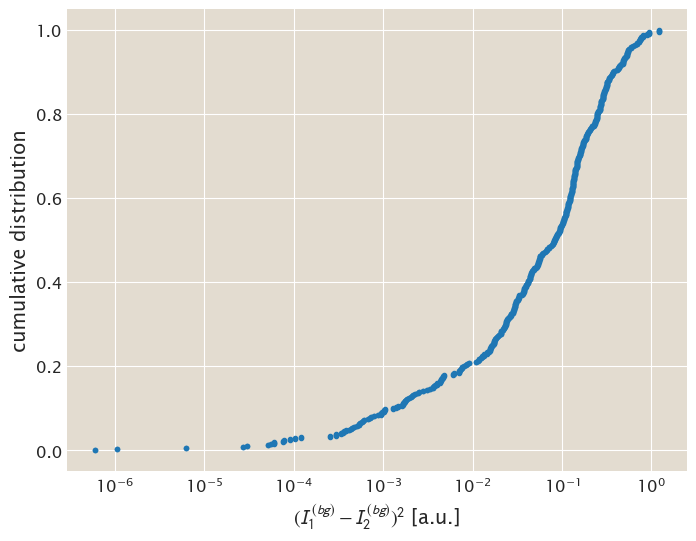

In [27]:
# Look at the distribution of the fluctuations
x, y = np.sort(bg_fluc), np.arange(len(bg_fluc)) / len(bg_fluc)
fig, ax  = plt.subplots(1, 1)
ax.set_xscale('log')
ax.set_xlabel('$(I_1^{(bg)} - I_2^{(bg)})^2$ [a.u.]')
ax.set_ylabel('cumulative distribution')
_ = ax.plot(x, y, '.')

Wow that is non-gaussian!  Either way, we can compute the mean fluctuation for the background.

##  Computing background fluctuations for each cell

Rather than computing the entire background fluctuation, let's just look at it on a cell-by-cell basis and compute a calibration factor for the background 

In [34]:
# Group by position and mother id
grouped = growth_df.groupby(['position', 'motherID'])
bg_df = pd.DataFrame([], columns=['I_1', 'I_2', 'summed', 'fluct'])
for g, d in grouped:
    if len(d) == 2:
        daughters = d['fluor1_bg_death_fluo'].values  * d['death_area'].values
        I_1, I_2 = daughters
        summed = np.sum(daughters)
        fluct = np.diff(daughters)[0]**2
        div_dict = {'I_1': I_1, 'I_2':I_2, 'summed':summed, 'fluct':fluct}
        bg_df = bg_df.append(div_dict, ignore_index=True)

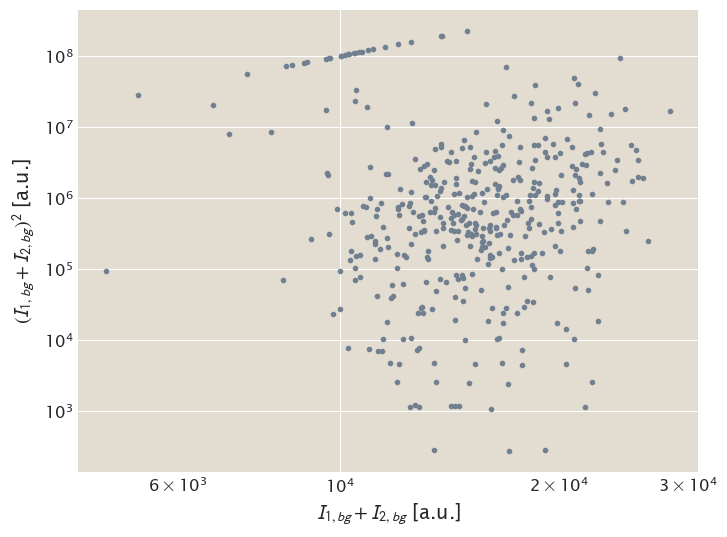

In [37]:
# Generate the scatter plot.
fig, ax = plt.subplots(1,1)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('$I_{1, bg} + I_{2, bg}$ [a.u.]')
ax.set_ylabel('$(I_{1, bg} + I_{2, bg})^2$ [a.u.]')
_ = ax.plot(bg_df['summed'], bg_df['fluct'], '.', color='slategray')

Now fit the calibration fator and bin.  

In [44]:
class DeterministicLogPosterior(pm.Continuous):
    def __init__(self, int_1=None, int_2=None, *args, **kwargs):
        super(DeterministicLogPosterior, self).__init__(*args, **kwargs) 
    def logp(self, value, *args):
        n1 = bg_df.I_1.values / value
        n2 = bg_df.I_2.values / value
        ntot = n1 + n2
        k = len(bg_df.I_1.values)
        binom = tt.sum(tt.gammaln(ntot+1)) - tt.sum(tt.gammaln(n1+1)) -tt.sum(tt.gammaln(n2+1))
        return -k * tt.log(value) + binom - tt.sum(ntot) * tt.log(2)

In [47]:
with pm.Model() as model:
    alpha = DeterministicLogPosterior('alpha', I_1, I_2, testval=100)
    trace = pm.sample(tune=5000, draws=5000, njobs=4)
    trace_df = pboc.mcmc.trace_to_dataframe(trace, model)
    stats = pboc.mcmc.compute_statistics(trace_df)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha]
100%|██████████| 10000/10000 [00:08<00:00, 1121.93it/s]


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1c24bd6b38>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x1c26e885f8>]], dtype=object)

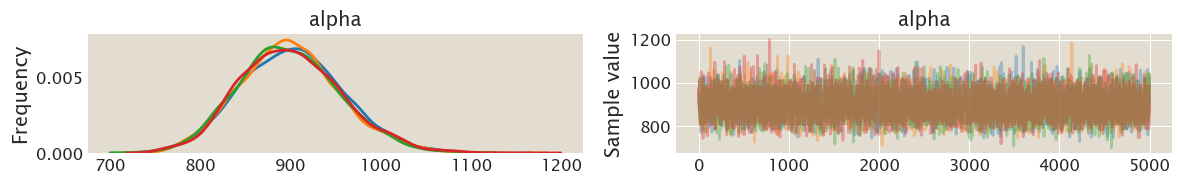

In [48]:
pm.traceplot(trace)

In [60]:
bin_size = 10
bins = np.arange(0, len(bg_df) + bin_size, bin_size)
sorted_df = bg_df.sort_values(['summed'])
mean_summed = np.zeros((len(bins) - 1))
mean_fluct = np.zeros((len(bins) - 1))
for i in range(1, len(bins)):
    slc = sorted_df.iloc[bins[i-1]:bins[i]]
    mean_summed[i-1] = slc['summed'].mean()
    mean_fluct[i-1] = slc['fluct'].mean()
    

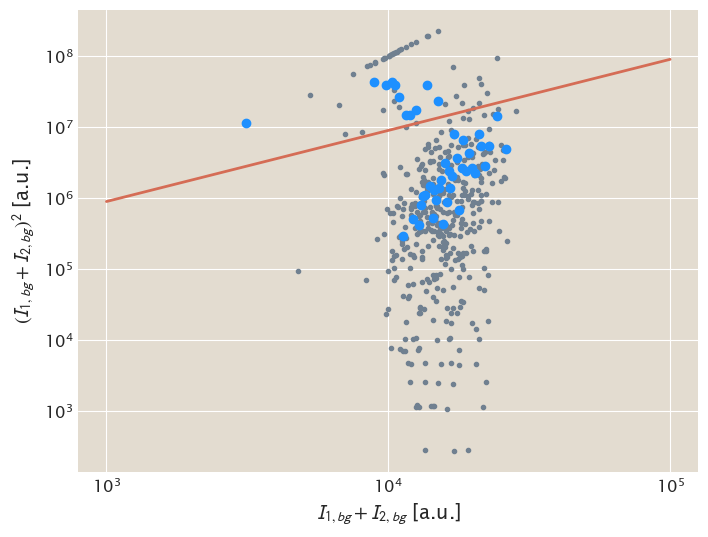

In [61]:
# Generate the scatter plot.
I_tot_range = np.logspace(3, 5)
theo = stats['mode'].values * I_tot_range

fig, ax = plt.subplots(1,1)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('$I_{1, bg} + I_{2, bg}$ [a.u.]')
ax.set_ylabel('$(I_{1, bg} + I_{2, bg})^2$ [a.u.]')
_ = ax.plot(bg_df['summed'], bg_df['fluct'], '.', color='slategray')
_ = ax.plot(mean_summed, mean_fluct, 'o', color='dodgerblue')
_ = ax.plot(I_tot_range, theo, '-', color=colors['red'])


In [62]:
bg_fluo = measured['fluor1_bg_death_fluo'].unique()

(array([  2.,   3.,   2.,   3.,  10.,   2.,   2.,   4.,   1.,   1.]),
 array([ 16.49558187,  16.60530723,  16.7150326 ,  16.82475796,
         16.93448332,  17.04420868,  17.15393405,  17.26365941,
         17.37338477,  17.48311013,  17.5928355 ]),
 <a list of 10 Patch objects>)

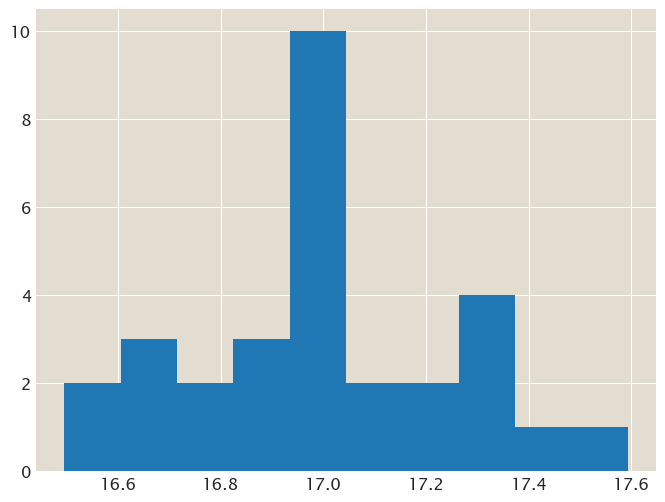

In [64]:
plt.hist(bg_fluo)

In [65]:
fano_bg = np.var(bg_fluo) / np.mean(bg_fluo)

In [66]:
fano_bg

0.0041705758578229665